<a href="https://colab.research.google.com/github/noamshimsho/NLP/blob/main/Chapter_6_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In This Notebook:

*   Seq2Seq - Summarization (cnn_dailymail, SAMSum)
*   Models (GPT-2, T5, BART, PEGASUS)
*   Evaluating Quality using BLEU and ROUGE
*   Fine-Tuning a Summarization Model

The final model: https://huggingface.co/GV05/pegasus-samsum


In [ ]:
!pip install -q transformers[sentencepiece] datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.5 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version="3.0.0")
print(f"Features: {dataset['train'].column_names}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['article', 'highlights', 'id']


In [ ]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 4051):

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['The U.S. are a country.', 'The U.N. is an organization.']

# Summarization Baseline

In [ ]:
sample_text = dataset["train"][1]["article"][:2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}

In [ ]:
# A common baseline for summarizing news articles is to simply take the first three sentences of the article
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])
summaries["baseline"] = three_sentence_summary(sample_text)

In [ ]:
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."'}

In [ ]:
from transformers import pipeline, set_seed

In [ ]:
# GPT-2
"""
One of the model’s surprising features is that we can also use it to generate summaries by simply appending “TL;DR” at the end of the input text. 
The expression “TL;DR” (too long; didn’t read) is often used on platforms like Reddit to indicate a short version of a long post.
"""


set_seed(42)
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."',
 'gpt2': '- Miami-Dade jails have more mentally ill inmates than other counties - About one-third of the mentally ill in Miami-Dade county are housed here - All the mentally ill prisoners have no shoes, no beds, and no mattresses\xa0 \n"You don\'t want to be the judge because you\'re dealing with a lot of people you don\'t know," Leif'}

In [ ]:
# T5
"""
The T5 checkpoints are trained on a mixture of unsupervised data (to reconstruct masked words) and supervised data for several tasks, including summarization. 
These checkpoints can thus be directly used to perform summarization without fine-tuning by using the same prompts used during pretraining.
"""
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."',
 'gpt2': '- Miami-Dade jails have more mentally ill inmates than other counties - About one-third of the mentally ill in Miami-Dade county are housed here - All the mentally ill prisoners have no shoes, no beds, and no mattresses\xa0 \n"You don\'t want to be the judge because you\'re dealing with a lot of people you don\'t know," Leif',
 't5': 'mentally ill inmates are housed on the ninth floor of a florida jail .\nmost face drug charges or charges of assaulting an officer .\njudge says arrests often res

In [ ]:
# BART
"""
We’ll use the facebook/bart-large-ccn checkpoint, which has been specifically fine-tuned on the CNN/DailyMail dataset:
"""
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."',
 'gpt2': '- Miami-Dade jails have more mentally ill inmates than other counties - About one-third of the mentally ill in Miami-Dade county are housed here - All the mentally ill prisoners have no shoes, no beds, and no mattresses\xa0 \n"You don\'t want to be the judge because you\'re dealing with a lot of people you don\'t know," Leif',
 't5': 'mentally ill inmates are housed on the ninth floor of a florida jail .\nmost face drug charges or charges of assaulting an officer .\njudge says arrests often res

In [ ]:
# PEGASUS
"""
Like BART, PEGASUS is an encoder-decoder transformer. its pretraining objective is to predict masked sentences in multisentence texts. 
The authors argue that the closer the pretraining objective is to the downstream task, the more effective it is. 
With the aim of finding a pretraining objective that is closer to summarization than general language modeling, they automatically identified, in a very large corpus, sentences containing most of the content of their surrounding paragraphs (using summarization evaluation metrics as a heuristic for content overlap) and pretrained the PEGASUS model to reconstruct these sentences, thereby obtaining a state-of-the-art model for text summarization.

We can see that the model mostly tries to summarize by extracting the key sentences from the dialogue.
"""
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [ ]:
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."',
 'gpt2': '- Miami-Dade jails have more mentally ill inmates than other counties - About one-third of the mentally ill in Miami-Dade county are housed here - All the mentally ill prisoners have no shoes, no beds, and no mattresses\xa0 \n"You don\'t want to be the judge because you\'re dealing with a lot of people you don\'t know," Leif',
 't5': 'mentally ill inmates are housed on the ninth floor of a florida jail .\nmost face drug charges or charges of assaulting an officer .\njudge says arrests often res

In [ ]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2
- Miami-Dade jails have more mentally ill inmates than other counties - About one-third of the mentally ill in Miami-Dade county are housed here - All the mentally ill prisoners have no shoes, no beds, and no mattresse

# Measuring the Quality of Generated Text BLEU and ROUGE

The idea of BLEU is simple: instead of looking at how many of the tokens in the generated texts are perfectly aligned with the reference text tokens, we look at words or n-grams. BLEU is a precision-based metric,

In [ ]:
!pip install sacrebleu

In [ ]:
sacrebleu = evaluate.load("sacrebleu")
print(sacrebleu.features)

[{'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}]


In [ ]:
import pandas as pd
import numpy as np

sacrebleu.add_batch(predictions=["the the the the the the"], references=[["the cat is on the mat"]])
results = sacrebleu.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


We can see the precision of the 1-gram is indeed 2/6, whereas the precisions for the 2/3/4-grams are all 0.

In [ ]:
sacrebleu.add_batch(predictions=["the cat is on mat"], references=[["the cat is on the mat"]])
results = sacrebleu.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


The ROUGE score was specifically developed for applications like summarization where high recall is more important than just precision

This was the original proposal for ROUGE. 

Subsequently, researchers have found that fully removing precision can have strong negative effects. 

Going back to the BLEU formula without the clipped counting, we can measure precision as well, and we can then combine both precision and recall ROUGE scores in the harmonic mean to get an F1-score. 

This score is the metric that is nowadays commonly reported for ROUGE.

In [ ]:
!pip install rouge_score

In [ ]:
from datasets import load_metric
rouge_metric = load_metric("rouge")

<ipython-input-36-76fa4d2ef6b0>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge")


In [ ]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.275229,0.093458,0.201835,0.275229
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.323232,0.206186,0.282828,0.323232


In [ ]:
rouge = evaluate.load("rouge")

In [ ]:
#rouge

In [ ]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
for model_name in summaries:

  prediction = summaries[model_name]
  results = rouge.compute(predictions=[prediction], references=[reference])
  records.append(results)

pd.DataFrame(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.275229,0.093458,0.201835,0.275229
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.323232,0.206186,0.282828,0.323232


# Evaluating PEGASUS on the CNN/DailyMail Dataset

We now have all the pieces in place to evaluate the model properly: we have a dataset with a test set from CNN/DailyMail, we have a metric with ROUGE, and we have a summarization model. We just need to put the pieces together. 

In [ ]:
# 3 sentences baseline
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article",
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries, references=dataset[column_summary])
    score = metric.compute()
    return score

In [ ]:
dataset["test"]

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 11490
})

In [ ]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(100))

score = evaluate_summaries_baseline(test_sampled, rouge)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.386229,0.16465,0.245916,0.352733


In [ ]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
  
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,    # tokenize the input
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),    # get model output ids
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,      # decode output from id to words
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]

        metric.add_batch(predictions=decoded_summaries, references=target_batch)# add to the metric

    score = metric.compute()
    return score

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

score = evaluate_summaries_pegasus(test_sampled, rouge, model, tokenizer, batch_size=1)


100%|██████████| 100/100 [03:40<00:00,  2.20s/it]


In [ ]:
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.425433,0.201681,0.300942,0.362527


# Training a Summarization Model

We’ve worked through a lot of details on text summarization and evaluation, so let’s put this to use to train a custom text summarization model! 

For our application, we’ll use the **SAMSum dataset** developed by Samsung, which consists of a collection of dialogues along with brief summaries.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [ ]:
!pip install py7zr

In [ ]:
from datasets import load_dataset
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


## Evaluating PEGASUS on SAMSum

In [ ]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [ ]:
score = evaluate_summaries_pegasus(dataset_samsum["test"].select(range(50)), rouge, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=1)


In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.276617,0.066181,0.202712,0.202734


## Fine-Tuning PEGASUS

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


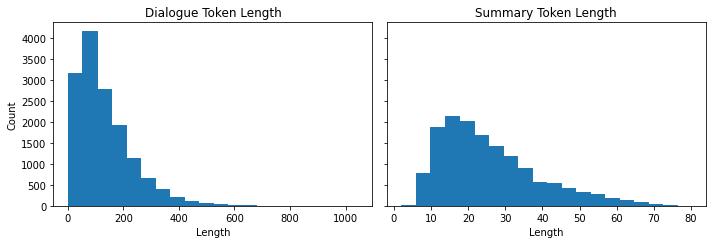

In [ ]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

We see that most dialogues are much shorter than the CNN/DailyMail articles, with 100–200 tokens per dialogue. 

Similarly, the summaries are much shorter, with around 20–40 tokens (the average length of a tweet).

In [ ]:
def convert_examples_to_features(example_batch):

    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, # tokenize the dialogue to maximum lengths of 1024 tokens
                                truncation=True)

    with tokenizer.as_target_tokenizer(): # Some models require special tokens in the decoder inputs, so it’s important to differentiate between the tokenization of encoder and decoder inputs.
        target_encodings = tokenizer(example_batch["summary"], max_length=128, # tokenize the summary to maximum lengths of 128 tokens
                                     truncation=True) 

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

  0%|          | 0/15 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
dataset_samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [ ]:
for k,v in dataset_samsum_pt['train'][0].items():
  print(k,v)

input_ids tensor([12195,   151,   125,  7091,  3659,   107,   842,   119,   245,   181,
          152, 10508,   151,  7435,   147, 12195,   151,   125,   131,   267,
          650,   119,  3469, 29344,     1])
attention_mask tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1])
labels tensor([12195,  7091,  3659,   111,   138,   650, 10508,   181,  3469,   107,
            1])


In [ ]:
tokenizer.decode(dataset_samsum_pt['train'][0]['labels'])

'Amanda baked cookies and will bring Jerry some tomorrow.</s>'

In most cases we can use the default collator, which collects all the tensors from the batch and simply stacks them. 

For the summarization task we need to not only stack the inputs but also prepare the targets on the decoder side. 

PEGASUS is an encoder-decoder transformer and thus has the classic seq2seq architecture. 

In a seq2seq setup, a common approach is to apply “teacher forcing” in the decoder, the decoder only sees the previous ground truth labels and not the current or future ones.

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

One thing that is different from the previous settings is that new argument, **gradient_accumulation_steps**. 

Since the model is quite big, we had to set the batch size to 1. However, a batch size that is too small can hurt convergence. 

To resolve that issue, we can use a nifty technique called gradient accumulation. 

As the name suggests, instead of calculating the gradients of the full batch all at once, we make smaller batches and aggregate the gradients. 

When we have aggregated enough gradients, we run the optimization step. Naturally this is a bit slower than doing it in one pass, but it saves us a lot of GPU memory.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: dialogue, id, summary. If dialogue, id, summary are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14732
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 920
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__ca

Step,Training Loss,Validation Loss
500,1.692800,1.481203


The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: dialogue, id, summary. If dialogue, id, summary are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=920, training_loss=1.8277016971422277, metrics={'train_runtime': 2610.4687, 'train_samples_per_second': 5.643, 'train_steps_per_second': 0.352, 'total_flos': 5526961323663360.0, 'train_loss': 1.8277016971422277, 'epoch': 1.0})

In [ ]:
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge, trainer.model, tokenizer,
    batch_size=1, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

100%|██████████| 819/819 [16:29<00:00,  1.21s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.429981,0.198859,0.342041,0.342093


In [ ]:
trainer.push_to_hub("Training complete!")

Saving model checkpoint to pegasus-samsum
Configuration saved in pegasus-samsum/config.json
Model weights saved in pegasus-samsum/pytorch_model.bin
tokenizer config file saved in pegasus-samsum/tokenizer_config.json
Special tokens file saved in pegasus-samsum/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 3.30k/2.13G [00:00<?, ?B/s]

Upload file spiece.model:   0%|          | 3.30k/1.82M [00:00<?, ?B/s]

Upload file runs/Dec22_14-21-41_4f67758c767a/1671718948.8104978/events.out.tfevents.1671718948.4f67758c767a.35…

Upload file training_args.bin: 100%|#########9| 3.30k/3.31k [00:00<?, ?B/s]

Upload file runs/Dec22_14-21-41_4f67758c767a/events.out.tfevents.1671718948.4f67758c767a.35353.0:  17%|#7     …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/GV05/pegasus-samsum
   b19722e..6a40beb  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/GV05/pegasus-samsum
   b19722e..6a40beb  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'dataset': {'name': 'samsum', 'type': 'samsum', 'config': 'samsum', 'split': 'train', 'args': 'samsum'}}
To https://huggingface.co/GV05/pegasus-samsum
   6a40beb..61d3cf6  main -> main

   6a40beb..61d3cf6  main -> main



'https://huggingface.co/GV05/pegasus-samsum/commit/6a40bebd1fdc78499d1f24ffe0f25a11e6d8829f'

# Final Result Dialogue Summaries!

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="GV05/pegasus-samsum")   # transformersbook/pegasus-samsum

In [ ]:
print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty's last time they were at the park together. Hannah wants Amanda to text him.


In [ ]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but you input_length is only 91. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Thom, Lewis and Leandro are going to write a book about transformers. Thom helped build a library by Hugging Face. They are going to do it together.


In [ ]:
import evaluate
evaluate.list_evaluation_modules(
  module_type="metric",
  include_community=False,
  with_details=True)[0:10]

[{'name': 'precision', 'type': 'metric', 'community': False, 'likes': 0},
 {'name': 'code_eval', 'type': 'metric', 'community': False, 'likes': 3},
 {'name': 'roc_auc', 'type': 'metric', 'community': False, 'likes': 0},
 {'name': 'cuad', 'type': 'metric', 'community': False, 'likes': 0},
 {'name': 'xnli', 'type': 'metric', 'community': False, 'likes': 0},
 {'name': 'rouge', 'type': 'metric', 'community': False, 'likes': 4},
 {'name': 'pearsonr', 'type': 'metric', 'community': False, 'likes': 1},
 {'name': 'mse', 'type': 'metric', 'community': False, 'likes': 0},
 {'name': 'super_glue', 'type': 'metric', 'community': False, 'likes': 1},
 {'name': 'comet', 'type': 'metric', 'community': False, 'likes': 0}]

In [ ]:
accuracy = evaluate.load("accuracy")
print(accuracy.description)
print("||||||||||||||")

"""
Note that features always describe the type of a single input element. In general we will add lists of elements so you can always think of a list around the types in features. 
Evaluate accepts various input formats (Python lists, NumPy arrays, PyTorch tensors, etc.) and converts them to an appropriate format for storage and computation.
"""
print(accuracy.features)


Accuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
 Where:
TP: True positive
TN: True negative
FP: False positive
FN: False negative

||||||||||||||
{'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}


In [ ]:
print(accuracy.compute(references=[0,1,0,1], predictions=[1,0,0,1]))
for ref, pred in zip([0,1,0,1], [1,0,0,1]):
    accuracy.add(references=ref, predictions=pred)
print(accuracy.compute())
for refs, preds in zip([[0,1],[0,1]], [[1,0],[0,1]]):
    accuracy.add_batch(references=refs, predictions=preds)
print(accuracy.compute())

{'accuracy': 0.5}
{'accuracy': 0.5}
{'accuracy': 0.5}


In [ ]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])
for refs, preds in zip([[0,1],[0,1]], [[1,0],[0,1]]):
    clf_metrics.add_batch(references=refs, predictions=preds)
clf_metrics.compute()

{'accuracy': 0.5, 'f1': 0.5, 'precision': 0.5, 'recall': 0.5}